In [1]:
%load_ext autoreload
%autoreload 2

import os, sys, shutil, bz2
from pathlib import Path
import pandas as pd
pd.set_option('display.max_columns', 50)
import numpy as np
from numpy.random import Generator, PCG64
rng_pg = Generator(PCG64())
from scipy.optimize import newton, minimize, fsolve
from scipy.optimize import nnls
import statsmodels.api as sm
import statsmodels.formula.api as smf

### Plotting imports ###
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib as mpl
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
palette = list(mcolors.TABLEAU_COLORS.keys())
sns.set_theme(style="ticks", palette="muted")
sns.set_context("notebook")
%matplotlib inline

from wand.image import Image as WImage

In [2]:
# Navigate back to NBdir in case of re-running a code block:
if not 'NBdir' in globals():
    NBdir = os.getcwd()
print('Notebook is in: {}'.format(NBdir))
os.chdir(NBdir)  # If you changed the current working dir, this will take you back to the notebook dir.

# Define the path to the repo folder.
# Change if necessary.
homedir = '/'.join(NBdir.split('/')[0:-2])
print('Repo is in: {}'.format(homedir))
sys.path.insert(1, homedir)
from src.stats_collection import STATS_collection
from src.plotting import TRNA_plot
from src.curve_fitting import loss_func_c1, loss_func_l1, loss_func_l2, hl_bsl_fit, bootstrap_hl, bootstrap_hl_fast, hl2_bsl_fit, obj_hl2_bsl_fit

# These are default folder names for data and raw fastq files
# relative to the folder in which this notebook is in:
data_dir = 'data'
stats_dir = 'stats_collection'
plotting_dir = 'plotting'

Notebook is in: /Users/krdav/Google Drive/MCB/Sullivan_lab/tRNA-charge-seq/projects/charge_half-life
Repo is in: /Users/krdav/Google Drive/MCB/Sullivan_lab/tRNA-charge-seq


# Charge titration to validate tRNA-charge sequencing approach
In this notebook I will process and analyze the samples generated to validate the tRNA-charge sequencing approach.
The summary of the finding of this analysis is:
* tRNA oxidation/cleavage goes to completion, thus the initial step of charge discrimination is quantitative 
* tRNA abundance is affected by the oxidation/cleavage reactions but relative abundance is comparable between samples that have undergone the same treatment
* tRNA charge can be determined quantitatively


### Sample description
To generate samples with known tRNA acetylation leves a mixture of intact and deacetylated tRNA was made.
The intact tRNA was isolated from a cell culture, split in two and one part deacylated before mixing them together at different ratios.
A titration was made to establish a linear range of tRNA charging quantification.
The titration spans 8 different ratios: 100/0, 85/15, 70/30, 55/45, 40/60, 25/75, 10/90, 0/100 of percentage charge/uncharge.

If there is a adapter ligation bias, this should reveal itself as a deviation from linearity between predicted and measured tRNA charge.
Because the substrate is a complex mix of tRNAs isolated from a cell culture, it will be possible to reveal ligation bias on the transcript level.



#### Protocol for preparing the tRNA titration
1. Isolate whole cell RNA from adherent cells using Trizol. Place dish on ice, thoroughly aspirate media, then add enough Trizol to cover the cells. From this point onwards, keep the RNA cold and work fast to retain tRNA acylation. Scrape cells and move to tube, add chloroform, vortex 5 min and spin. Precipitate RNA with IPA, spin and wash the pellet twice in acetate buffered 80% IPA (pH=4.5), then do a final wash in 100% IPA and dry RNA pellet. Dry RNA pellets can be stored at -80C for months without detectable loss of acetylation.
2. Prepare deacetylated tRNA by taking a tube with whole cell RNA, reconstituting it with 100 mM sodium acetate, pH=4.5, measure the RNA concentration and adjust it to 1 ug/uL. Add 50 uL 1M lysine (pH=8) per 10 uL RNA and incubate 4 h at 45C. After incubation, lower the pH by adding 10 uL 11 M sodium acetate per 10 uL RNA, then precipitate, wash and reconstitute with 100 mM sodium acetate, pH=4.5, measure the RNA concentration and adjust it to 1 ug/uL.
3. Prepare intact tRNA by taking a tube with whole cell RNA and reconstituting it with 100 mM sodium acetate, pH=4.5, measure the RNA concentration and adjust it to 1 ug/uL.
4. Make a titration of the following percentages of intact/deacylated RNA: 100/0, 85/15, 70/30, 55/45, 40/60, 25/75, 10/90, 0/100
5. Perform periodate oxidation, including adding E.coli control, and subsequent steps following the tRNA-charge-seq protocol with the appropriate scaling
6. At the adapter ligation step, use multiple adapters for each titration ratio to get barcode level replicates


### Read and filter input data
A sample list is provided to filter the samples for further use and add relevant sample level information.
The data is read from a .csv file with aggregated sample statistics.
This .csv file was generated using the standard process described in the tRNA-seq-charge repo and is the result of using the `STATS_collection` class.
Below the `TRNA_plot` class is used to extract the relevant tRNA charge information at transcript level.

In [75]:
sample_list_fnam = 'sample_list.xlsx'
sample_df = pd.read_excel('{}/{}'.format(NBdir, sample_list_fnam))
# Isolate the half-life samples:
mask = (sample_df['plot_group'] == 'Acylation-half-life')
# mask &= (sample_df['barcode'] != 'l4Sp')
# mask &= np.array([fn[0:10] == '2022-12-28' for fn in sample_df['fastq_mate1_filename']])
sample_df = sample_df[mask].reset_index(drop=True).copy()
sample_df['run_v1'] = np.array([fn[0:10] == '2022-12-28' for fn in sample_df['fastq_mate1_filename']])

# Make a dictionary with paths used for data processing:
dir_dict = dict(NBdir = NBdir,
                data_dir = data_dir,
                stats_dir = stats_dir,
                plotting_dir = plotting_dir)

# Get charge dataframe for aggregated stats:
plot_obj = TRNA_plot(dir_dict, sample_df=sample_df, \
                     stats_fnam='ALL_stats_aggregate.csv', \
                     overwrite_dir=False)
plot_obj.get_charge_df()

Folder exists and overwrite set to false... Doing nothing.


In [76]:
# Add E.coli control RPM to sample level information:
ectr = plot_obj.charge_filt['tr'][plot_obj.charge_filt['tr']['Ecoli_ctr']].copy()
sample_df = ectr.loc[:, ['sample_name_unique', 'RPM']].merge(sample_df, on='sample_name_unique')
sample_df = sample_df.rename(columns={'RPM': 'RPM_Ectr'}, errors='ignore')

# Extract dataframe with charge and add sample information:
charge_df = sample_df.loc[:, ['sample_name_unique', 'hue_value', 'hue_order', 'RPM_Ectr', 'run_v1']].merge(plot_obj.charge_filt['tr'], on='sample_name_unique')

# Convert time to minutes:
time_list = list()
for sn in charge_df['sample_name']:
    if 'NoOx' in sn:
        time_list.append(None)
    elif 'm' in sn:
        time_list.append(int(sn[:-1]))
    elif 'h' in sn:
        time_list.append(int(sn[:-1])*60)
    else:
        raise Exception('???')
charge_df['Time'] = time_list
charge_df['tRNA_anno_short'] = ['mito-'+an if mc else an for an, mc in zip(charge_df['tRNA_anno_short'], charge_df['mito_codon'])]

In [77]:
# Enforce minimum read count:
min_count = 1000
# For each tRNA annotation, find samples
# that have above the minimum count:
tann2snu = dict()
for snu, tann, ectr, cnt in zip(charge_df['sample_name_unique'], \
                               charge_df['tRNA_annotation'], \
                               charge_df['Ecoli_ctr'], \
                               charge_df['count']):
    if ectr or cnt < min_count:
        continue
    
    if tann in tann2snu:
        tann2snu[tann].add(snu)
    else:
        tann2snu[tann] = set()
        tann2snu[tann].add(snu)

# Filter tRNA annotation based on
# all samples having above the minimum count:
all_snu = set(charge_df['sample_name_unique'])
tann_sele = set()
for tann in tann2snu:
    if tann2snu[tann] == all_snu:
        tann_sele.add(tann)
mask = charge_df['tRNA_annotation'].isin(tann_sele)
filt_df = charge_df[mask].copy()
filt_df = filt_df[~filt_df['Time'].isna()].copy()
filt_df['RPM_norm'] = filt_df['RPM'] / filt_df['RPM_Ectr']

# Create dataframe for each tRNA annotation.
# To this the aminoacylatio half-life will be added later.
hl_df = filt_df.groupby(['tRNA_annotation', 'tRNA_anno_short', 'tRNA_annotation_len', 'codon', 'anticodon', 'AA_codon', 'amino_acid', 'AA_letter', 'mito_codon', 'Ecoli_ctr']).agg({'RPM': 'mean', 'RPM_norm': 'mean', 'RPM_Ectr': 'mean', 'count': 'mean'}).reset_index()

### Check data integrity
Ploting the "charge" of the E.coli control tRNA in each sample.

The E.coli control was added to check that the NaIO4 oxidation and lysine cleavage reaction goes to completion and therefore should appear as 0% charged (i.e. all CC, no CCA); however, typically, a smaller percentage remains intact and thus will appear as charged.
This, is also apparent below where most samples have a measured charge for the E.coli control samples of ~1% and only two samples are above 2%.
Whether this small residual "charge" reflects the incompletion of the NaIO4 oxidation and lysine cleavage reaction or is a sequencing artifact is unknown, but we take it that the levels are so low that for most pratical purposes, including this analysis, the reaction can be assumed complete.

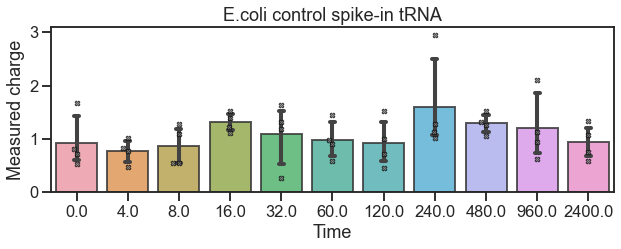

In [78]:
# Select E.coli controls samples:
ectr_mask = charge_df['Ecoli_ctr']
fig, ax1 = plt.subplots(1, 1, figsize=(9, 3.8))

g1 = sns.barplot(ax=ax1, data=charge_df[ectr_mask], x='Time', y='charge', \
                 capsize=0.1, edgecolor=".2", linewidth=2, alpha=0.8)
g1 = sns.swarmplot(ax=ax1, data=charge_df[ectr_mask], x='Time', y='charge', \
                   color='grey', alpha=0.8, edgecolor='black', linewidth=0.8, \
                   size=5, marker="X")
g1.set(xlabel='Time', ylabel='Measured charge')
g1.set_title('E.coli control spike-in tRNA')
fig.tight_layout()
fig.savefig('data/plotting/ecoli-control_charge.pdf', bbox_inches='tight')

### Predicted vs. measured tRNA charge
As described in the above protocol, the RNA concentrations were measured and adjusted before mixing a known ratio of intact and deacylated RNA; however, it is not given that the RNA concentration is 100% accurate and it is also not known whether some tRNAs are preferentially accumulating as a result of the deacylation step.
We will remain agnostic to both of these possibilities by assuming that the concentration of each tRNA transcript is unknown in the deacylated sample.

Half-life

$$
N(t) = N_0 \left( \frac{1}{2} \right) ^\frac{t}{t_{1/2}} + N_{\infty}
$$

$$
log_2(N(t) - N_{\infty}) = log_2(N_0) - \frac{t}{t_{1/2}}
$$

$$
log_2(N(t) - N_{\infty}) = log_2(N_0) - t \frac{1}{t_{1/2}}
$$

$$
t_{1/2} = \frac{t}{log_2(N_0) - log_2(N(t) - N_{\infty})}
$$



In [79]:
# Function to plot the time-series
# charge data along with the fitted half-life function:
def plot_hl(df, p_est, ci, plot_return=True, plot_fh=None):
    fig = plt.figure(figsize=(16, 5))
    gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 1])
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])
    
    # Half-life fit and confidence interval:
    fit_x = np.linspace(df['Time'].min(), df['Time'].max(), 1000)
    fit_y = hl_bsl_fit(fit_x, *p_est)
    fit_yb = hl_bsl_fit(fit_x, *ci[0])
    fit_yt = hl_bsl_fit(fit_x, *ci[1])

    # No transformation:
    g1 = sns.scatterplot(ax=ax1, data=df, x='Time', y='charge', style='replicate', \
                         markers=True, zorder=10, alpha=0.5, \
                         edgecolor='black', linewidth=0.7, legend=False)
    g1.set_title('No transform')
    g1.set(xlabel='Time (min)', ylabel='Charge (%)')
    ax1.plot(fit_x, fit_yb, c='g', ls='--', zorder=1)
    ax1.plot(fit_x, fit_yt, c='g', ls='--', zorder=2)
    ax1.plot(fit_x, fit_y, c='r', zorder=3)

    # Log transformed y-axis:
    g2 = sns.scatterplot(ax=ax2, data=df, x='Time', y='charge', style='replicate', \
                         markers=True,  zorder=10, alpha=0.5, \
                         edgecolor='black', linewidth=0.7, legend=False)
    g2.set_title('Log2 y')
    g2.set(xlabel='Time (min)', ylabel='Charge (%)')
    g2.set_yscale('log', base=2)
    ax2.plot(fit_x, fit_yb, c='g', ls='--', zorder=1)
    ax2.plot(fit_x, fit_yt, c='g', ls='--', zorder=2)
    ax2.plot(fit_x, fit_y, c='r', zorder=3)

    # # Log transformed x-axis:
    df['Time+1'] = df['Time'] + (df['Time'] == 0) * 1
    g3 = sns.scatterplot(ax=ax3, data=df, x='Time+1', y='charge', style='replicate', \
                         markers=True,  zorder=10, alpha=0.5, \
                         edgecolor='black', linewidth=0.7)
    g3.set(xlabel='Time (min)', ylabel='Charge (%)')
    g3.set_title('Log2 x')
    g3.set_xscale('log', base=2)
    sns.move_legend(g3, "upper left", bbox_to_anchor=(1.01, 1.03), ncol=1, title='Replicate')
    ax3.plot(fit_x, fit_yb, c='g', ls='--', zorder=1)
    ax3.plot(fit_x, fit_yt, c='g', ls='--', zorder=2)
    ax3.plot(fit_x, fit_y, c='r', zorder=3)

    tRNA_name = df['tRNA_anno_short'].values[0]
    fig.suptitle('{} half-life={:.0f} min, 95% CI ({:.0f}; {:.0f})'.format(tRNA_name, p_est[1], ci[0][1], ci[1][1]), size=16);
    fig.tight_layout()
    
    if not plot_fh is None:
        plot_fh.savefig(fig, bbox_inches='tight')
    else:
        fig.savefig('data/plotting/{}.pdf'.format(tRNA_name), bbox_inches='tight')
    if plot_return is False:
        plt.close(fig)


In [105]:
# Run analysis on half-life data
# one tRNA transcript at the time:
res = list()
pred_list = list()
index_list = list()
with PdfPages('data/plotting/hl-fit.pdf') as pp:
    for tann in hl_df['tRNA_annotation']:
        # Extract dataframe with single tRNA annotation:
        sample_mask = filt_df['tRNA_annotation'] == tann
        hl_spl = filt_df[sample_mask].copy()
        # Infer half-life point estimate and 
        # bootstrap the confidence interval:
        residual, p_est, ci = bootstrap_hl(hl_spl, Ndraws=100, BFGS_loss_func=loss_func_l2, lstsq=False)
        pred = hl_bsl_fit(hl_spl['Time'].values, *p_est)
        pred_list.extend(pred)
        index_list.extend(hl_spl.index.values)

        # Plot the fit:
        aa = hl_spl['tRNA_anno_short'].values[0].split('-')[0]
        plot_hl(hl_spl, p_est, ci, plot_fh=pp, plot_return=False)
        # Store results:
        res.append([residual, residual_l1, ci_resiual_l1, p_est[1], \
                    ci[0][1], ci[1][1], (p_est, ci)])

# Add results to dataframe:
hl_df['hl_residual'] = [row[0] for row in res] # these are taken on the mean replicate charge
hl_df['hl_p_est'] = [row[3] for row in res]
hl_df['res_ci_l'] = [row[4] for row in res]
hl_df['res_ci_u'] = [row[5] for row in res]
hl_df['res_param'] = [row[6] for row in res]

# Add results to sample level information:
filt_df['charge_pred'] = 0
filt_df.loc[index_list, 'charge_pred'] = pred_list
filt_df['pred_err'] = filt_df['charge'] - filt_df['charge_pred']

We can check the results by looking at the fit for a random trancript.
The left scatterplot shows the measured charge as a function of time.
It shows an exponential decay of charge with a fitted decay function as a red line and the 95% confidence interval of this in dashed green lines.
The middle plot has been log transformed on the y-axis to show the linear relationship that results.
Because a minimum charge parameter is included in the decay function it bends off to a lower asymptote.
The right plot has been log transformed on the x-axis.
This is for visual purpose to spread out the timepoints.
Also notice that time 0 has been set to 1 to avoid $\text{log2}(0)$.

Generally, the replicates show similar charge, the points fall close to the fitted decay function and the confince interval is narrow.
This all confirms that this tRNA sequencing method can be used to measure the aminoacylation half-life of individual tRNA transcripts pooled together.

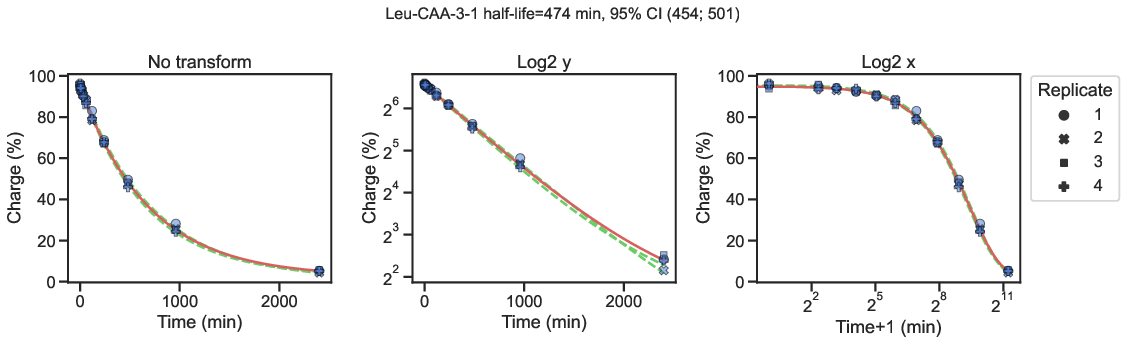

In [9]:
random_image = np.random.randint(len(hl_df['tRNA_annotation']))
img = WImage(filename='data/plotting/hl-fit.pdf[{}]'.format(random_image))
img

However, there are some transcripts were the decay function does not seem to fit the data so well.
One example is mitochondrial methionine tRNA which is used in mitochondrial translation both as an initiator and in normal elongation.
As an initator the methionine is formylated while attached to the tRNA (fMet), thus two different aminoacylation species can exist.
This could explain the deviation from the, implicitly assumed, single species decay function.

First let us look more formally at the largest sum of squared residuals for the annotations:

In [207]:
hl_df.sort_values(by='hl_residual', ascending=False).reset_index().loc[0:30, ['tRNA_anno_short', 'hl_residual']].head(20)

,tRNA_anno_short,hl_residual
0,mito-Met-CAT,132.789178
1,SeC-TCA-1-1,62.335383
2,Gln-TTG-1-1,30.169005
3,Gln-TTG-2-1,29.211206
4,Cys-GCA-9-1,16.632923
5,Cys-GCA-4-1,15.918616
6,Cys-GCA-6-1,13.752846
7,Gln-TTG-3-1,13.294279
8,Gln-CTG-4-1,13.180241
9,Gln-CTG-2-1,12.859420


The residuals validate that mitochondrial methionine tRNA is not modeled well by the decay function, but also selenocysteine (SeC) is having high residuals.
Coincidentally, like mito-Met/fMet, SeC is also modified on the tRNA.
Initially, the SeC-tRNA is aminoacylated with serine, then this serine is phosphorylated and finally the phosphate is replaced by selenium to make selenocysteine.
In this case three aminoacylation species could exist.

As we go down the list several Gln/Cys codons have high residuals, although small compared to mito-Met and SeC.
However, these look distinct from mito-Met and SeC and appear to have a large residual due to high replicate variance rather than bad decay function fit.

Nevertheless, it is trivial to model a two species decay function with species $A$ and $B$:
$$
N(t) = N^A_0 \left( \frac{1}{2} \right) ^\frac{t}{t^A_{1/2}} + N^B_0 \left( \frac{1}{2} \right) ^\frac{t}{t^B_{1/2}} + N_{\infty}
$$

Here $N^A_0$ and $N^B_0$ are the initial percentage point charge of species $A$ and $B$ and each have an associated half-life $t^A_{1/2}$ and $t^B_{1/2}$, respectively.
Thus, the model goes from three parameters to five.

Below, we shall see how this two species model fit the data.

In [244]:
# Function to test the two-species model:
def test_two_species(inp_df, short_anno):
    sample_mask = inp_df['tRNA_anno_short'] == short_anno
    df = filt_df[sample_mask].copy()
    ch_dat = dict()
    for t, ch in zip(df['Time'], df['charge']):
        if t in ch_dat:
            ch_dat[t].append(ch)
        else:
            ch_dat[t] = list()
            ch_dat[t].append(ch)

    time_arr = np.array(list(ch_dat.keys()))
    mean = np.zeros(len(ch_dat))

    # Allow two species:
    bnds = ((0, 100), (0, 100), (1, 1e5), (1, 1e5), (0, 2.5))
    guess = (90, 10, 5000, 50, 1)
    for i, t in enumerate(time_arr):
        mean[i] = np.mean(ch_dat[t])
    def fun_hl2_bsl(p): return(obj_hl2_bsl_fit(loss_func_l2, mean, time_arr, p))
    p_hl_bsl = minimize(fun_hl2_bsl, guess, method='L-BFGS-B', bounds=bnds)
    
    return((p_hl_bsl.fun, p_hl_bsl.x))


In [ ]:
# Function to plot the comparison between
# a one and a two species model:
def compare_one_two(df, p1, p2, plot_return=True):
    fig = plt.figure(figsize=(16, 5))
    gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 1])
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])

    # Half-life fit and confidence interval:
    fit_x = np.linspace(df['Time'].min(), df['Time'].max(), 1000)
    fit_y1 = hl_bsl_fit(fit_x, *p1)
    fit_y2 = hl2_bsl_fit(fit_x, *p2)

    # No transformation:
    g1 = sns.scatterplot(ax=ax1, data=df, x='Time', y='charge', style='replicate', \
                         markers=True, zorder=10, alpha=0.5, \
                         edgecolor='black', linewidth=0.7, legend=False)
    g1.set_title('No transform')
    g1.set(xlabel='Time (min)', ylabel='Charge (%)')
    ax1.plot(fit_x, fit_y1, c='g', zorder=2)
    ax1.plot(fit_x, fit_y2, c='r', zorder=3)

    # Log transformed y-axis:
    g2 = sns.scatterplot(ax=ax2, data=df, x='Time', y='charge', style='replicate', \
                         markers=True,  zorder=10, alpha=0.5, \
                         edgecolor='black', linewidth=0.7, legend=False)
    g2.set_title('Log2 y')
    g2.set(xlabel='Time (min)', ylabel='Charge (%)')
    g2.set_yscale('log', base=2)
    ax2.plot(fit_x, fit_y1, c='g', zorder=2)
    ax2.plot(fit_x, fit_y2, c='r', zorder=3)

    # # Log transformed x-axis:
    df['Time+1'] = df['Time'] + (df['Time'] == 0) * 1
    g3 = sns.scatterplot(ax=ax3, data=df, x='Time+1', y='charge', style='replicate', \
                         markers=True,  zorder=10, alpha=0.5, \
                         edgecolor='black', linewidth=0.7)
    g3.set(xlabel='Time (min)', ylabel='Charge (%)')
    g3.set_title('Log2 x')
    g3.set_xscale('log', base=2)
    sns.move_legend(g3, "upper left", bbox_to_anchor=(1.01, 1.03), ncol=1, title='Replicate')
    ax3.plot(fit_x, fit_y1, c='g', zorder=2)
    ax3.plot(fit_x, fit_y2, c='r', zorder=3)

    tRNA_name = df['tRNA_anno_short'].values[0]
    fig.suptitle('{}, two-species at [{:.0f}, {:.0f}] percentage point initial charge, half-life=[{:.0f}, {:.0f}] min'.format(tRNA_name, *p2), size=16);
    fig.tight_layout()
    fig.savefig('data/plotting/{}_two-species_model.pdf'.format(tRNA_name), bbox_inches='tight')
    if plot_return is False:
        plt.close(fig)

In [249]:
# Fit a two species model to each transcript
# and see how this affects the residuals:
two_fit = [test_two_species(filt_df, ta) for ta in hl_df['tRNA_anno_short']]
hl_df['two_fit_residual'] = [tf[0] for tf in two_fit]
hl_df['two_fit_params'] = [tf[1] for tf in two_fit]
hl_df['one-two_resi'] = hl_df['hl_residual'] / hl_df['two_fit_residual']
hl_df.sort_values(by='one-two_resi', ascending=False).loc[:, ['tRNA_anno_short', 'hl_residual', 'one-two_resi']].head(8)

,tRNA_anno_short,hl_residual,one-two_resi
13,mito-Met-CAT,132.789178,148.424950
132,SeC-TCA-1-1,62.335383,49.452404
97,Ile-TAT-2-1,1.237827,15.605116
165,Val-AAC-1-1,2.784254,10.760922
166,Val-AAC-2-1,1.685401,10.535318
96,Ile-TAT-1-1,2.256321,6.306597
168,Val-CAC-1-1,1.292254,5.954006
172,Val-TAC-1-1,0.246635,3.981719


In the list above the `one-two_resi` column is the residual of the one species model devided by those from the two species model.
Clearly, mito-Met and SeC have a massively improved fit which we will see plotted below.
Some isoleucine and valine tRNAs are also better; however, these transcripts already have low residuals with the one species model and thus this will remain their preferred model.

The plots below have similar layout as those plots used for single species decay function fit, without the confidence interval.
The green line is the one species model, the red line is the two species model.
From the figure title we can see that at time zero the mito-Met is inferred to be 53% aminoacylated with species A, 41% aminoacylated with species B and 6% unaminoacylated.
We can also read that species A is inferred to have a half-life of 3586 min, whereas species B has a half-life of 387 min.
Species B is likely methionine which has a similar half-life (~450 min) when attached to cytoplasmic tRNAs.
Species A would then be formyl-methionine, so why is fMet aminoacylation so much more stable?
Probably, because the N-formyl group shifts electrons towards to aminoacyl ester bond making it less
susceptible to nucleophilic attack.

For SeC, the major species A has an inferred half-life of 417 min, which is right between the ~600 and ~200 min of Ser and Cys, respectively.
The minor species B has a short half-life of only 17 min.
If true, this would be the shortest amino acylation half-life measured in this experiment.
It seems most likely that the major species is the actual product: selenocysteine, and since species B has such short half-life it is most likely the intermediate phosphoserine.

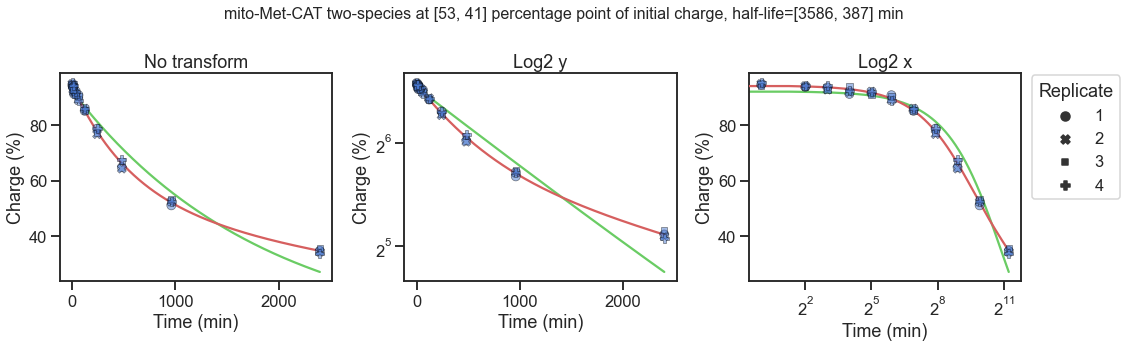

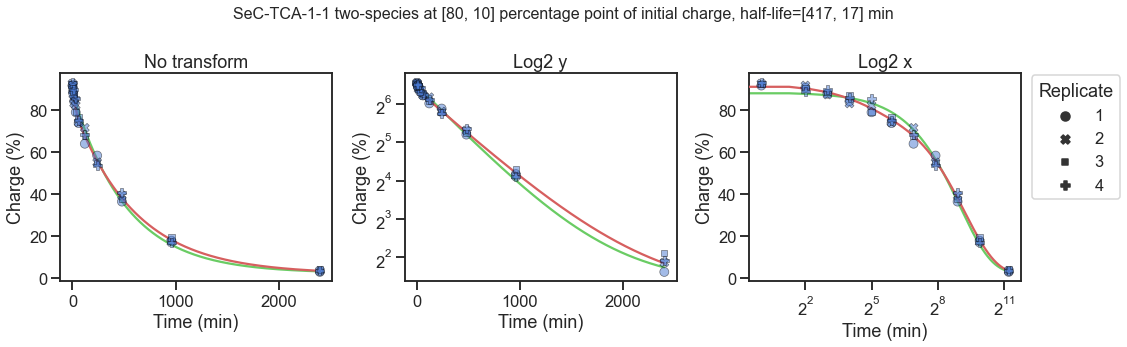

In [250]:
# Plot the comparison betwen one and two species models:
for anno in ['mito-Met-CAT', 'SeC-TCA-1-1']:
    sample_mask = filt_df['tRNA_anno_short'] == anno
    hl_spl = filt_df[sample_mask].copy()
    hl_anno_mask = hl_df['tRNA_anno_short'] == anno
    p1 = hl_df.loc[hl_anno_mask, 'res_param'].values[0][0]
    p2 = hl_df.loc[hl_anno_mask, 'two_fit_params'].values[0]
    compare_one_two(hl_spl, p1, p2)

In [213]:
p_est, ci = bootstrap_hl(hl_spl, Ndraws=1000, BFGS_loss_func=loss_func_l2, lstsq=True)

In [132]:
print(p_est)
print(ci)

(96.00474752710623, 418.44841794653644, 0.42539364086634457)
[(97.05385278784854, 393.6679576101668, 0.42539364086634457), (94.69207270285224, 447.44237397425564, 0.42539364086634457)]


In [118]:
bootstrap_hl(hl_spl, Ndraws=10000, BFGS_loss_func=loss_func_c1, lstsq=True)

((395.8547889285526, 96.79094314272555, 0.8346930017495829),
 array([367.10449724, 428.02401717]))

In [211]:
p_est, ci = bootstrap_hl(hl_spl, Ndraws=1000, BFGS_loss_func=loss_func_l2, lstsq=False)

In [120]:
bootstrap_hl(hl_spl, Ndraws=1000, BFGS_loss_func=loss_func_c1, lstsq=False)

((396.1452773604278, 96.6949805416293, 0.8346930017495829),
 array([372.97732558, 416.04601084]))

In [25]:
# Fast version only works when same number of replicates in all timepoints:
#bootstrap_hl_fast(hl_spl, Ndraws=100000, BFGS_loss_func=loss_func_l2)

In [26]:
#bootstrap_hl_fast(hl_spl, Ndraws=100000, BFGS_loss_func=loss_func_c1)

In [ ]:
#bootstrap_hl_fast(hl_spl, Ndraws=100000, BFGS_loss_func=loss_func_c1, minus_N_bz=0)

In [235]:
hl_spl.head(3)

,sample_name_unique,hue_value,hue_order,sample_name,replicate,barcode,tRNA_annotation,tRNA_anno_short,tRNA_annotation_len,codon,anticodon,AA_codon,amino_acid,AA_letter,mito_codon,Ecoli_ctr,count,A_count,C_count,RPM,charge,Time
206,0m_1,0m,1,0m,1,l1Sp,Homo_sapiens_tRNA-Ser-GCT-1-1,Ser-GCT-1-1,85,AGC,GCT,Ser-AGC,Ser,S,False,False,5746,4699,1047,1049.031736,81.778629,0.0
468,8m_1,8m,3,8m,1,l3Sp,Homo_sapiens_tRNA-Ser-GCT-1-1,Ser-GCT-1-1,85,AGC,GCT,Ser-AGC,Ser,S,False,False,4071,3321,750,1010.884828,81.577008,8.0
735,32m_1,32m,5,32m,1,l5Sp,Homo_sapiens_tRNA-Ser-GCT-1-1,Ser-GCT-1-1,85,AGC,GCT,Ser-AGC,Ser,S,False,False,5499,4382,1117,1002.503067,79.687216,32.0


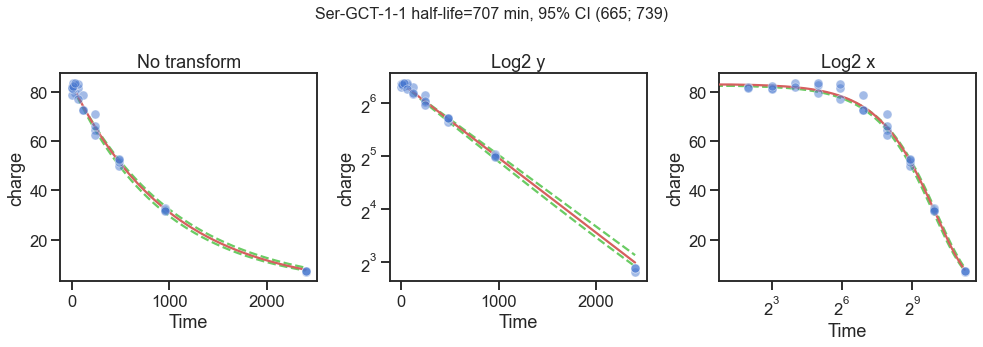

In [238]:
plot_hl(hl_spl, p_est, ci)